In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab
from pylab import *
import matplotlib.dates as mdate
from numpy import genfromtxt
import fnmatch
import os
import math
from matplotlib.transforms import BlendedGenericTransform

%matplotlib inline

In [2]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def process_dir(dir_name, process_throughput):
    if process_throughput:
        # throughput
        t_raw = np.sort(genfromtxt(dir_name + '/throughput.csv', delimiter=',')[:,1])
        rec_count = np.max((10, t_raw.shape[0]))
        t_extracted = t_raw[:rec_count]
        t_mean = np.mean(t_extracted)
        t_std = np.std(t_extracted)

    #latency
    data = []
    for file in os.listdir(dir_name):
        if fnmatch.fnmatch(file, '*.qstat'):
            l_data = genfromtxt(dir_name + '/' + os.path.basename(file), delimiter=',')
            filtered = l_data[nonzero(l_data[:,2])]
            filtered2 = filtered[nonzero(filtered[:,1])]
            data.append(filtered2[:,1].reshape((filtered2[:,1].shape[0],1)))
    
    print('Processed file count: ', len(os.listdir(dir_name)))
    #full_l_data = reject_outliers(np.vstack(data)/math.pow(10,6), 5)
    full_l_data = np.vstack(data)/math.pow(10,6)
    l_mean = np.mean(full_l_data)
    print("mean: ", l_mean)
    l_std = np.std(full_l_data)
    l_q5 = np.percentile(full_l_data, 5)
    l_q25 = np.percentile(full_l_data, 25)
    l_q50 = np.percentile(full_l_data, 50)
    l_q75 = np.percentile(full_l_data, 75)
    l_q95 = np.percentile(full_l_data, 95)
    if process_throughput:
        stats = (t_mean, t_std, l_mean, l_std, l_q5, l_q25, l_q50, l_q75, l_q95)
    else:
        stats = (l_mean, l_std, l_q5, l_q25, l_q50, l_q75, l_q95)
    #print(stats)
    return stats

In [ ]:
dirs = ('c1', 'c5', 'c10', 'c50', 'c100', 'c200', 'c300', 'c400', 'c500')
rel_data = []
md_data = []

for dir_ in dirs:
    rel_data.append(process_dir('attempts/nov10/relational-query/' + dir_, True))

for dir_ in dirs:
    md_data.append(process_dir('attempts/nov10/metadata-query/' + dir_, True))

rq_data = np.array(rel_data)
mq_data = np.array(md_data)

Processed file count:  2
mean:  37.8761900991
Processed file count:  7
mean:  62.3741634073
Processed file count:  11
mean:  48.7177055324
Processed file count:  51
mean:  241.269883123
Processed file count:  101
mean:  332.735188819
Processed file count:  201
mean:  448.880339818
Processed file count:  301
mean:  582.190056535
Processed file count:  401
mean:  849.332252668
Processed file count:  501
mean:  1013.64642502
Processed file count:  2
mean:  1.4983147266
Processed file count:  6
mean:  1.3053657792
Processed file count:  11
mean:  1.26522467521
Processed file count:  51
mean:  1.18053243992


In [5]:
rq_data = np.loadtxt('./summary/nov10_relational_query_summary.txt')
mq_data = np.loadtxt('./summary/nov10_metadata_query_summary.txt')
r_q50 = np.reshape(rq_data[:,6], (rq_data.shape[0], 1))
r_q5 = rq_data[:,6] - rq_data[:,4]
r_q25 = rq_data[:,6] - rq_data[:,5]
r_q75 = rq_data[:,7] - rq_data[:,6]
r_q95 = rq_data[:,8] - rq_data[:,6]

m_q50 = np.reshape(mq_data[:,6], mq_data.shape[0], 1)
m_q5 = mq_data[:,6] - mq_data[:,4]
m_q25 = mq_data[:,6] - mq_data[:,5]
m_q75 = mq_data[:,7] - mq_data[:,6]
m_q95 = mq_data[:,8] - mq_data[:,6]
print("Relational Data: ",rq_data.shape)
print("MD Data: ",mq_data.shape)
#np.savetxt('./summary/nov10_relational_query_summary.txt', rq_data)
#np.savetxt('./summary/nov10_metadata_query_summary.txt', mq_data)

Relational Data:  (9, 9)
MD Data:  (9, 9)


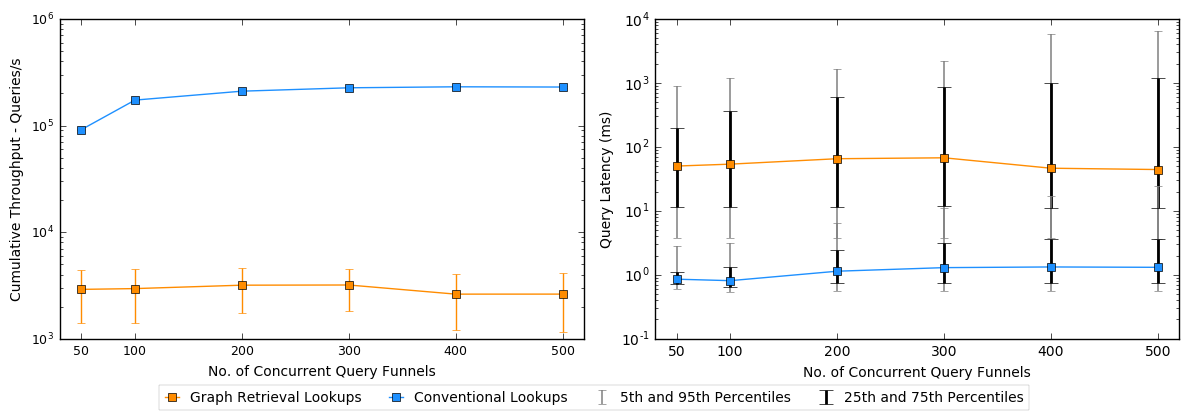

In [9]:
#m_q50[2] = m_q50[2] - 0.3
#r_q50[7] = r_q50[7] + 20
#r_q50[8] = r_q50[8] + 20

x_vals = [1, 5, 10, 50, 100, 200, 300, 400, 500]
x = 3
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1,2,1)
leg_t_rq = ax.errorbar(x_vals[x:], rq_data[x:,0], yerr=rq_data[x:,1], color='darkorange', label='Graph Retrieval Lookups', marker='s')
leg_t_mq = ax.errorbar(x_vals[x:], mq_data[x:,0], yerr=mq_data[x:,1], color='dodgerblue', label='Conventional Lookups', marker='s')
ax.set_yscale("log", nonposy='clip')

pylab.xlabel('No. of Concurrent Query Funnels', fontsize=10)
pylab.ylabel('Cumulative Throughput - Queries/s', fontsize=10)
plt.tick_params(axis='x', which='major', labelsize=9)
plt.tick_params(axis='y', which='major', labelsize=9)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.xticks(x_vals[x:])
plt.xlim(30,520)

ax2 = plt.subplot(1,2,2)
ax2.set_yscale("log", nonposy='clip')

leg_r = ax2.plot(x_vals[x:], r_q50[x:], color='darkorange', lw=1, label='Graph Retrieval Lookups', marker='s')
leg_r_q95 = ax2.errorbar(x_vals[x:], r_q50[x:], yerr=np.vstack([r_q5[x:], r_q95[x:]]), label='5th and 95th Percentiles', 
                       ecolor='grey', color='white', lw=0.01, capsize=3, elinewidth=1.1)
leg_r_q75 = ax2.errorbar(x_vals[x:], r_q50[x:], yerr=np.vstack([r_q25[x:], r_q75[x:]]), lw=0.0, label='25th and 75th Percentiles', 
                       ecolor='black', color='white', capsize=5, elinewidth=2.0)

leg_m = ax2.plot(x_vals[x:], m_q50[x:], color='dodgerblue', lw=1, label='Conventional Lookups', marker='s')
leg_m_q95 = ax2.errorbar(x_vals[x:], m_q50[x:], yerr=np.vstack([m_q5[x:], m_q95[x:]]), 
                       ecolor='grey', color='white', lw=0.001, capsize=3, elinewidth=1.1)
leg_m_q75 = ax2.errorbar(x_vals[x:], m_q50[x:], yerr=np.vstack([m_q25[x:], m_q75[x:]]), lw=0.0, 
                       ecolor='black', color='white', capsize=5, elinewidth=2.0)


plt.xticks(x_vals[x:])
pylab.ylabel('Query Latency (ms)', fontsize=10)
pylab.xlabel('No. of Concurrent Query Funnels', fontsize=10)
plt.xlim(30,520)

lns, labs = ax2.get_legend_handles_labels()
leg = fig.legend(handles=lns, labels=labs, fontsize=10, ncol=4, loc='upper center', borderaxespad=0.1, handlelength=1, 
                  bbox_to_anchor=(0.5, -0.14), numpoints = 1, 
                 bbox_transform=BlendedGenericTransform(fig.transFigure, ax.transAxes))
leg.get_frame().set_linewidth(0.1)
pylab.tight_layout()

fig.savefig('attempts/nov10/figs/query_benchmark_both.pdf', dpi=300, bbox_extra_artists=(leg,), bbox_inches='tight')

#fig.savefig('./figs/query_benchmark.pdf', dpi=300, bbox_extra_artists=(leg,), bbox_inches='tight')
#fig.savefig('attempts/nov6/figs/query_benchmark_t.pdf', dpi=300, bbox_extra_artists=(leg,), bbox_inches='tight')